# Comparing Transect Data at the Tanana River Test Site 

The TRTS is located near Nenana, Alaska, and was first investigated as a test site in 2008 after a CEC deployment in Eagle Alaska ended early due to debris-related issues.  Since then, it has become an established test site with modular deployment infrastructure that can be adapted for different CEC deployments. The TRTS allows CECs to be tested in a harsh environment with cold temperatures, sediment, and heavy debris, representing the conditions of many remote Alaska river communities that could greatly benefit from ME. The following example will familiarize the user with the MHKiT DOLfYN and Delft3D modules by performing a Deflt3d numerical model validation of the Tanana River Test Site (TRTS) against field data.

Start by importing the necessary python packages and MHKiT module.

In [1]:
from os.path import abspath, dirname, join, normpath, relpath
from matplotlib.pyplot import figure
import scipy.interpolate as interp
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
import pandas as pd
import numpy as np
import scipy.io
import netCDF4
import math 
import utm
# MHKiT Imports
from mhkit.dolfyn.rotate import api as ap
from mhkit.dolfyn.adp import api
from mhkit import dolfyn as dlfn
from mhkit.river.io import d3d 
from mhkit import river

## 1. Preparing the ADCP Field Data

Acoustic Dopple Curent Profiler (ADCP) field data was collected in 2010 on the Tanana river near Nenana. From the picture shown below the flow can be seen enetering the picture from the bottom heading north. The figure further shows the two passes (Transects) of  data collected. The data is collected using a barge used with a debris shield infront to protect instruments and test devices. The transect we are looking at are up-steam of the testing barge making them a good repesentiaion of the flow field the Curent Energy Convertes (CEC) are operating in. This transect data was collected using a Teledyne Rio Grand ADCP monted at the Bow of the boat facing downward. The boat faced and moved perpendicular to the river flow across the river as the ADCP was recording.  

In the next section we will import the two transects shown here into MHKiT and then interpolate these two passes into a single idealized transect for comparison with the simulated Deflt3D data.

<img src="data/river/ADCP_transect/TRTS_transect_map.png" width=1080 height=920  />

### ADCP: Importing Data

The MHKiT DOLfYN api module can import `.PDO` and other binary formats from ADCP and ADV to an xarray. For this analysis we import two transect passes stored in the 'data' folder in `.PDO` format. For comparison to the numerical model we want to average the two transects into one xarray ('transect_1_2').

In [2]:
# Read in the two transect passes
transect_1_raw = api.read('data/river/ADCP_transect/tanana_transects_08_10_10_0_002_10-08-10_142214.PD0') 
transect_2_raw = api.read('data/river/ADCP_transect/tanana_transects_08_10_10_0_003_10-08-10_143335.PD0')
# Create one dataset from the two passes
transect_1_2= xr.merge([transect_1_raw, transect_2_raw])
# Print the xarray data
transect_1_2


Reading file data/river/ADCP_transect/tanana_transects_08_10_10_0_002_10-08-10_142214.PD0 ...

Reading file data/river/ADCP_transect/tanana_transects_08_10_10_0_003_10-08-10_143335.PD0 ...


<xarray.Dataset>
Dimensions:              (time_gps: 1171, time: 1171, beam: 4, dir: 4, range: 47, x: 4, x*: 4, earth: 3, inst: 3)
Coordinates:
  * time_gps             (time_gps) datetime64[ns] 2010-08-10T22:28:17.200000...
  * time                 (time) datetime64[ns] 2010-08-10T14:28:15.559999942 ...
  * beam                 (beam) int32 1 2 3 4
  * dir                  (dir) <U3 'X' 'Y' 'Z' 'err'
  * range                (range) float64 0.57 0.82 1.07 ... 11.57 11.82 12.07
  * x                    (x) int32 1 2 3 4
  * x*                   (x*) int32 1 2 3 4
  * earth                (earth) <U1 'E' 'N' 'U'
  * inst                 (inst) <U1 'X' 'Y' 'Z'
Data variables: (12/36)
    number               (time) float64 3.652e+03 3.653e+03 ... 4.882e+03
    builtin_test_fail    (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    c_sound              (time) float32 1.466e+03 1.466e+03 ... 1.466e+03
    depth                (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pitch                (time) float32 -0.1 -0.09 -0.21 ... -0.37 -0.29 -0.11
    roll                 (time) float32 3.33 3.32 3.33 3.49 ... 2.34 2.37 2.38
    ...                   ...
    rtk_age_gps          (time_gps) float32 5.0 6.0 2.0 3.0 ... 2.0 2.0 3.0 3.0
    speed_over_grnd_gps  (time_gps) float32 0.03549 0.03395 ... 0.2541 0.285
    dir_over_grnd_gps    (time_gps) float32 115.5 94.08 6.931 ... 262.1 261.0
    hdwtime_gps          (time_gps) datetime64[ns] 2010-08-10T14:28:15.559999...
    beam2inst_orientmat  (x, x*) float64 1.462 -1.462 0.0 ... -1.034 -1.034
    orientmat            (earth, inst, time) float64 -0.9037 -0.9025 ... 1.0 1.0
Attributes: (12/38)
    inst_make:                TRDI
    inst_type:                ADCP
    rotate_vars:              ['vel', 'vel_bt']
    has_imu:                  0
    prog_ver:                 10.16
    inst_model:               Rio Grande
    ...                       ...
    false_target_threshold:   50
    transmit_lag_m:           0.08
    bandwidth:                0
    sourceprog:               WINRIVER
    fs:                       11.11111111111111
    vel_gps_corrected:        0

### ADCP: Convert the Coordinate System to UTM

By default, the ADCP coordinates are stored as latitude and longitude coordinates. However, latitude and longitude cannot be directly converted to a distance therefor here we convert from latitude and longitude to $UTM_x$ and $UTM_y$. This gives us the ability to calculate the linear line of best fit for the idealized transect.

In [3]:
# Convert Coordiantes to UTM using utm module
utm_x_y = utm.from_latlon(
    transect_1_2.latitude_gps, 
    transect_1_2.longitude_gps, 
    6,'W'
    ) 

# Create a DataFrame from the points 
gps = [[x, y] for x, y in zip(utm_x_y[0], utm_x_y[1])]     
gps_points = pd.DataFrame(np.array(gps), columns= ['utm_x','utm_y'])

### ADCP: Declination 
The magnetic declination cause data to be rotated slightly this can be corrected using MHKiT DOLfYN's rotate api `set_declination`. If magnetic declination has already been accounted for with the deployment software, it will be saved under the attributes `magnetic_var_deg` for Teledyne instruments. The variable `magnetic_var_deg` is unaltered by the function `set_declination` as it creates a new variable (`declination`).

In [4]:
# Nenana Alaska is 15.7 deg East
angle = 15.7
ap.set_declination(transect_1_2, angle, inplace=True) 

### ADCP: Rotation of Data Coordinate System  

Based on the deployment setting the coordinate system is set to "beam","inst","earth", or "principal". Using the `rotate2` function the coordinate system can by changed to fit the needs of the analysis. The `inplace` set as true will alter the input dataset "in place", eg. it does not create a new dataset.  This is further explained in the river_example ipython notebook.

In [5]:
# Rotate to 'earth' coordinate system 
api.rotate2(transect_1_2, 'earth', inplace=True)

### ADCP: Ideal Transect 

To perform a Delft3D transect comparison with the ADCP data an "ideal transect", defined as a straight path perpendicular to the flow that the boat was aiming for, was processed from the ADCP field data. Using the combined `transect_1_2` dataset a first degree numpy polyfit function (linear regression) was used to find a slope and intercept. Using the equation we can calculate $UTM_y$ coordinates to create an ideal linear transect. The resultant ideal transect is shown in the figure below.

Text(0, 0.5, '$UTM_y (m)$')

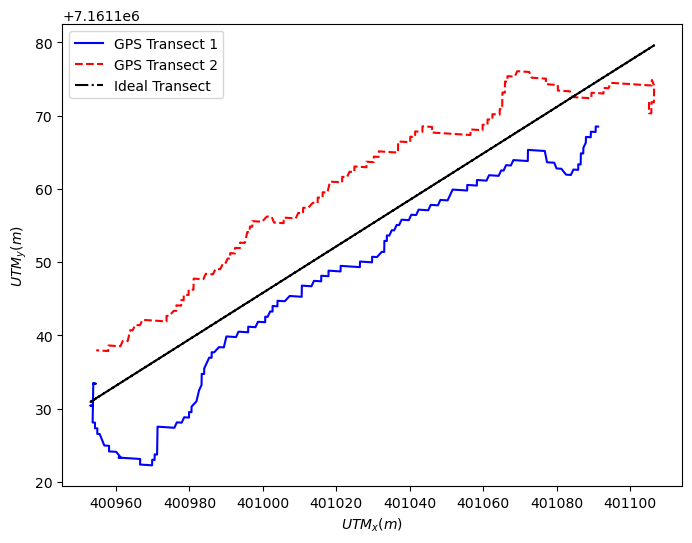

In [6]:
# Linear regression using first order polyfit
a,b = np.polyfit(gps_points.utm_x, gps_points.utm_y,1)

# Generate a DataFrame of points from the linear regression
ideal= [ [x, y] for x, y in zip(gps_points.utm_x, a*gps_points.utm_x+b)] 
ideal_points = pd.DataFrame(np.array(ideal), columns= ['utm_x','utm_y'])

# Repeat UTM corrdinates to match the ADCP points matrix (dir, range, time)
utm_x_points = np.tile(gps_points.utm_x, np.size(transect_1_2.range))
utm_y_points = np.tile(a*gps_points.utm_x+b, np.size(transect_1_2.range))
depth_points = np.repeat( transect_1_2.range, np.size(gps_points.utm_x))

ADCP_ideal_points={
    'utm_x': utm_x_points, 
    'utm_y': utm_y_points, 
    'waterdepth': depth_points
    }
ADCP_ideal_points=pd.DataFrame(ADCP_ideal_points)

# Initialize the figure
figure(figsize=(8,6))

# Get data from the original transect in UTM for comparison
transect_1 = utm.from_latlon(transect_1_raw.latitude_gps, transect_1_raw.longitude_gps, 6, 'W') 
transect_2 = utm.from_latlon(transect_2_raw.latitude_gps, transect_2_raw.longitude_gps, 6, 'W') 

# Plot the original transect data for comparison
plt.plot(transect_1[0],transect_1[1], 'b', label= 'GPS Transect 1' )
plt.plot(transect_2[0],transect_2[1], 'r--', label= 'GPS Transect 2')

# Plot the Idealized Transect
plt.plot(ADCP_ideal_points.utm_x, ADCP_ideal_points.utm_y, 'k-.', label='Ideal Transect')

# Plot Settings
plt.legend()
plt.xlabel('$UTM_x (m)$')
plt.ylabel('$UTM_y (m)$')

### ADCP: Range Offset

Depending on where the ADCP is deployed the `range` values might need to be offset by the deployment depth. For the TRTS dataset used here the range was corrected during the deployment setup, therefore, a zero-input used. This step is provided as a reference for other users.

In [7]:
# Adjust the range offset, included here for reference
offset=0
api.clean.set_range_offset(transect_1_2, offset)

### ADCP: Correlation Filter 
Correlation is a measure of data quality, and its output is scaled in units such that the expected correlation (given high signal/noise ratio, S/N) is 128. Here data was fileted for a minimum correlation of 40 counts. [https://www.comm-tec.com/Docs/Manuali/RDI/BBPRIME.pdf]

Looking at the plot in the figure below the ADCP is facing downward from the surface of the river and is defined as a range of 0. This means the top of the river is at the bottom of the plot. This ADCP has 4 beams the plot shown is one the 4 beams. From the plot of one of the beams shown below we can see that some of the values below the river bottom are filtered out.

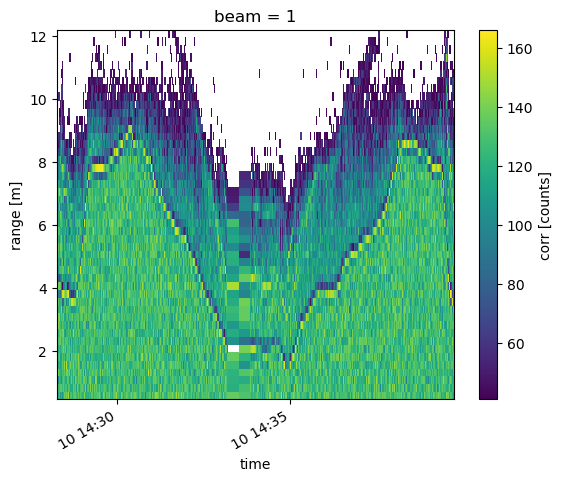

In [8]:
# Apply the correlation filter
min_correlation=40
transect_1_2 = api.clean.correlation_filter(transect_1_2, thresh=min_correlation)

# Plot the results the (data is displayed upside-down)
transect_1_2.corr.sel(beam=1).plot() 

### ADCP: River Bottom Filter 
MHKiT DOLfYN has the functionality to find the river bottom based on the along-beam acoustic amplitude data recorded from the ADCP. However, if depth sounder data is available it can be more reliable at representing the river bottom. Here we use the depth sounder (`depth_sounder`) to create an array that can be used as a filter when multiplied with the velocity data.

In [9]:
# Filtering out depth sounder values above the river surface
depth_sounder = transect_1_2.where(transect_1_2.dist_bt > 0 )

# Of the 4 values beams get the shallowest depth value at each location
bottom = np.min(depth_sounder.dist_bt, axis=0)

# River bottom for ideal transect 
bottom_avg = interp.griddata(gps_points, bottom, ideal_points, method='linear')

# Create a matrix of depths
bottom_filter = d3d.create_points(x=bottom_avg, y=transect_1_2.range.to_numpy(), waterdepth=1)

# Creating a mask matrix with ones in the area of the river cross section and nan's outside 
river_bottom_filter = []
for index, row in  bottom_filter.iterrows():
    if row['x'] > row['y']: 
        filter = 1    
    else: 
        filter = float("nan")
    river_bottom_filter = np.append(river_bottom_filter, filter)

[0, 1, 2]


### ADCP: Get Original Transect Data 

Here we create a DataFrame of the original velocity components from the transect data. This DataFrame will be used to interpolate the velocity data onto the ideal transect.

In [10]:
# Tiling the GPS data for each depth bin
gps_utm_x = np.tile(
    gps_points.utm_x, 
    np.size(transect_1_2.range)
    )
gps_utm_y = np.tile(
    gps_points.utm_y, 
    np.size(transect_1_2.range)
    )

# Repeating the depth bins for each GPS point
depth = np.repeat( 
    transect_1_2.range, 
    np.size(gps_points.utm_x)
    )

# Create Dataframe from the calculated points
ADCP_points = pd.DataFrame({
    'utm_x': gps_utm_x, 
    'utm_y': gps_utm_y, 
    'waterdepth': depth
    })

# Raveling the veocity data to correspond with 'ADCP_points' and filtering out velocity data bellow the river bottom 
ADCP_points['east_velocity']= np.ravel(transect_1_2.vel[0, :,:]) * river_bottom_filter
ADCP_points['north_velocity']= np.ravel(transect_1_2.vel[1, :,:]) * river_bottom_filter
ADCP_points['vertical_velocity']= np.ravel(transect_1_2.vel[2, :,:])* river_bottom_filter
ADCP_points= ADCP_points.dropna()

# Show points
ADCP_points

,utm_x,utm_y,waterdepth,east_velocity,north_velocity,vertical_velocity
0,400953.813014,7.161133e+06,0.57,-0.094245,0.214233,-0.010
1,400953.813014,7.161133e+06,0.57,0.181185,0.079026,0.022
2,400953.813014,7.161133e+06,0.57,-0.143789,0.129486,-0.119
3,400953.813014,7.161133e+06,0.57,-0.432847,0.519561,-0.095
4,400953.813014,7.161133e+06,0.57,-0.258352,0.393507,-0.106
...,...,...,...,...,...,...
36171,400989.066656,7.161150e+06,8.07,0.074346,1.819609,0.084
37323,400993.746501,7.161153e+06,8.32,0.409135,0.774590,0.055
37324,400993.746501,7.161153e+06,8.32,0.230414,0.237873,0.038
37328,400992.412805,7.161152e+06,8.32,0.381595,0.560519,0.104


### ADCP: Interpolating Velocities for Ideal Transect 

Using the original transect data saved in `ADCP_points` the velocity values are interpolated onto the ideal transect points using the scipy interpolate `griddata` function. 

In [11]:
# Project velocity onto ideal tansect 
ADCP_ideal= pd.DataFrame()
ADCP_ideal['east_velocity'] =  interp.griddata(
    ADCP_points[['utm_x','utm_y','waterdepth']],
    ADCP_points['east_velocity'],
    ADCP_ideal_points[['utm_x','utm_y','waterdepth']],
    method='linear'
    )
ADCP_ideal['north_velocity'] = interp.griddata(
    ADCP_points[['utm_x','utm_y','waterdepth']],
    ADCP_points['north_velocity'],
    ADCP_ideal_points[['utm_x','utm_y','waterdepth']],
    method='linear'
    )
ADCP_ideal['vertical_velocity'] = interp.griddata(
        ADCP_points[['utm_x','utm_y','waterdepth']],
    ADCP_points['vertical_velocity'],
    ADCP_ideal_points[['utm_x','utm_y','waterdepth']],
    method='linear'
    )

# Calculate the magnitude of the velocity components
ADCP_ideal['magnitude']= np.sqrt(ADCP_ideal.east_velocity**2+ADCP_ideal.north_velocity**2+ADCP_ideal.vertical_velocity**2)

Using the calculated magnitude of velocity from the ADCP we can create a contour plot of the velocity magnitude. 

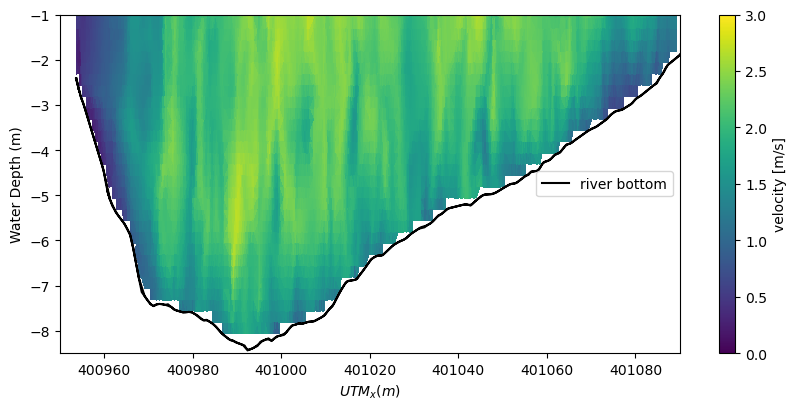

In [12]:
# Set the contour color bar bounds
min_plot=0
max_plot=3

# The Contour of velocity magnitude from the ADCP transect data 
plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
    ADCP_ideal_points.utm_x, 
    -ADCP_ideal_points.waterdepth, 
    ADCP_ideal.magnitude*river_bottom_filter,
    vmin=min_plot,
    vmax=max_plot
)

plt.xlabel('$UTM_x (m)$')
plt.ylabel('Water Depth (m)')
cbar= plt.colorbar(contour_plot)
cbar.set_label('velocity [m/s]')
plt.ylim([-8.5,-1])
plt.xlim([400950,401090])
plt.plot(ideal_points.utm_x,-bottom_avg,'k', label= 'river bottom')
plt.legend(loc= 7)

### ADCP: Ideal Transect Down-sampled

Numerical models such as Delft3D use discretized points to represent the domain. Environmental models tend to have a low number of points to represent large continuous areas. For instance, the bird's eye view of Delft3D only calculated numerical effects at a roughly 5m by 5m square. Delft3D then discretizes the depth with an even percentage from the water level to the bed by 12 layers as specified for this initial case. As the collected ADCP data had far more resolution than the numerical model a down-sampling was applied using an average to match the locations at which the Delft3D model returned data. This roughly equated to ten velocity measurements spanning the width of the river and 12 measurments spanning the depth.

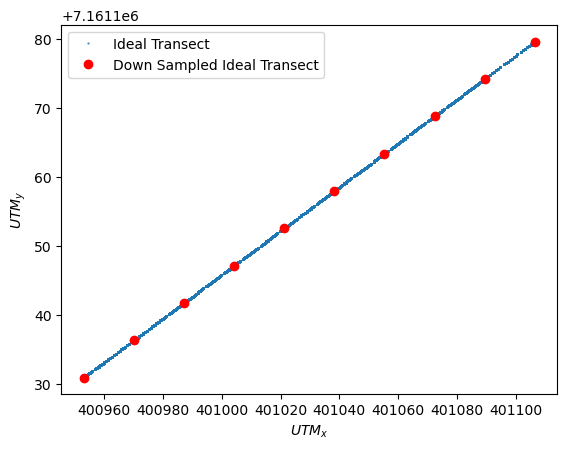

In [13]:
# Interpolate points by getting min & max first
start_utmx  = min(ADCP_ideal_points.utm_x)
start_utmy = min(ADCP_ideal_points.utm_y)

end_utmx = max(ADCP_ideal_points.utm_x)
end_utmy = min(ADCP_ideal_points.utm_y)

# Using N points for x calculate the y values on an ideal transect from the linear regression used earlier
N=10
utm_x_ideal_downsampeled = np.linspace(start_utmx, end_utmx, N)
utm_y_ideal_downsampeled = (a*utm_x_ideal_downsampeled) + b



# Plot the Idealized Transect for comparison
plt.plot(
    ADCP_ideal_points.utm_x, 
    ADCP_ideal_points.utm_y, 
    '.', ms=1, label='Ideal Transect'
    )

# Plot the downsampled transect
plt.plot(
    utm_x_ideal_downsampeled, 
    utm_y_ideal_downsampeled, 
    'ro', label='Down Sampled Ideal Transect')


# Plot settings
plt.xlabel('$UTM_x$')
plt.ylabel('$UTM_y$')
plt.legend()

With our down-sampled x,y points we can now create a down-sampled z at our x,y locations. As shown in the figure red dots below the river bottom will be excluded from the interpolation. 

Text(0, 0.5, '$ Depth [m]$')

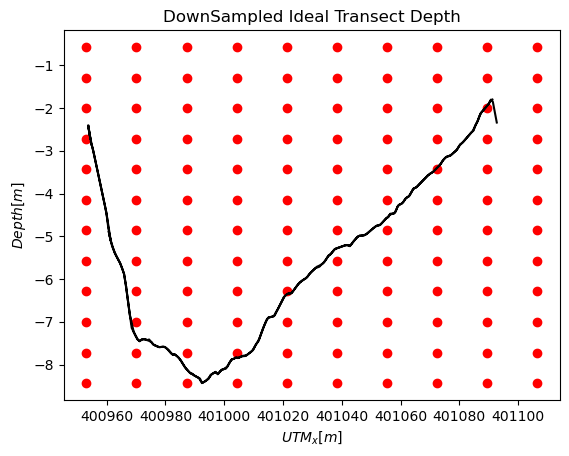

In [14]:
# Create an idealized depth N layers deep
N_layers=12
downsampled_depth = np.linspace(
    transect_1_2.range.min(), 
    np.nanmax(bottom_avg), 
    N_layers
    )

# Repeat this over the N points of the DownSampled Ideal Transect above 
depth_ideal_points_downsampled = np.repeat(
    downsampled_depth,
    N
    )

# Tile the x, y over the N of layers to add to a DataFrame
utm_x_ideal_points_downsampled= np.tile(
    utm_x_ideal_downsampeled, 
    N_layers
    )
utm_y_ideal_points_downsampled= np.tile(
    utm_y_ideal_downsampeled, 
    N_layers
    )

# Create a Dataframe of our idealized x,y,depth points
ADCP_ideal_points_downsamples=pd.DataFrame({
    'utm_x': utm_x_ideal_points_downsampled, 
    'utm_y': utm_y_ideal_points_downsampled,
    'waterdepth': depth_ideal_points_downsampled
    })

# Plot the Down sampled data points at the x locations
plt.plot(ADCP_ideal_points_downsamples.utm_x, 
         ADCP_ideal_points_downsamples.waterdepth * -1, 
         'ro',          
        )

# Plot the ADCP river bed
plt.plot(ideal_points.utm_x,-bottom_avg,'k', label= 'river bottom')

# Plot settings
plt.title('DownSampled Ideal Transect Depth')
plt.xlabel('$UTM_x [m]$')
plt.ylabel('$ Depth [m]$')

### ADCP: Interpolating the Downsampled Velocites for the Ideal Transect 

The above process of creating a `river_bottom_filter` and interpolating onto the ideal transect is repeated for the down-sampled grid shown in the figure above.  The depth sounder data is saved above in the variable `'bottom'` and used again here.  

In [15]:
# Project velocity onto ideal tansect  
ADCP_ideal_downsamples= pd.DataFrame()
ADCP_ideal_downsamples['east_velocity']=  interp.griddata(
    ADCP_points[['utm_x','utm_y','waterdepth']],
    ADCP_points['east_velocity'],
    ADCP_ideal_points_downsamples[['utm_x','utm_y','waterdepth']],
    method='linear'
    )
ADCP_ideal_downsamples['north_velocity']= interp.griddata(
    ADCP_points[['utm_x','utm_y','waterdepth']],
    ADCP_points['north_velocity'],
    ADCP_ideal_points_downsamples[['utm_x','utm_y','waterdepth']],
    method='linear'
)
ADCP_ideal_downsamples['vertical_velocity']=  interp.griddata(
        ADCP_points[['utm_x','utm_y','waterdepth']],
    ADCP_points['vertical_velocity'],
    ADCP_ideal_points_downsamples[['utm_x','utm_y','waterdepth']],
    method='linear'
    )
ADCP_ideal_downsamples['magnitude']= np.sqrt(ADCP_ideal_downsamples.east_velocity**2+ADCP_ideal_downsamples.north_velocity**2+ADCP_ideal_downsamples.vertical_velocity**2)
ADCP_ideal_downsamples

,east_velocity,north_velocity,vertical_velocity,magnitude
0,NaN,NaN,NaN,NaN
1,-0.300636,1.421535,0.042712,1.453605
2,-0.758431,1.832806,-0.016720,1.983601
3,-0.972110,2.340159,-0.043599,2.534412
4,-1.011364,2.046775,-0.034462,2.283273
...,...,...,...,...
115,NaN,NaN,NaN,NaN
116,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN
118,NaN,NaN,NaN,NaN


### ADCP: Plot Down-Sampled Ideal Transect 

To plot the contour of the ideal sample points we need to first create a mask to remove data outside of the river bottom because the ideal transect grid (shown as red dots in the figure above) includes points below the river bottom. 

In [16]:
# Create a DataFrame of downsampled points
ideal_downsampeled= [ [x, y] for x, y in zip(utm_x_ideal_downsampeled, utm_y_ideal_downsampeled)] 
ideal_points_downsampled = pd.DataFrame(np.array(ideal_downsampeled), columns= ['utm_x','utm_y'])

# River bottom for downsampled ideal transect  
bottom_avg_downsampled= interp.griddata(gps_points, bottom, ideal_points_downsampled, method='linear')

# Create a matrix of depths
bottom_filter_downsampled = d3d.create_points(x=bottom_avg_downsampled, y=downsampled_depth, waterdepth=1)

# Creating a mask matrix with ones in the area of the river cross section and nan's outside 
river_bottom_filter_downsampled= []
for index, row in  bottom_filter_downsampled.iterrows():
    if row['x'] > row['y']: 
        filter= 1    
    else: 
        filter= float("nan")
    river_bottom_filter_downsampled= np.append(river_bottom_filter_downsampled, filter)

[0, 1, 2]


Using our down-sampled velocity magnitude a contour plot is created. For comparison the river bottom from the original ideal transect is shown. 

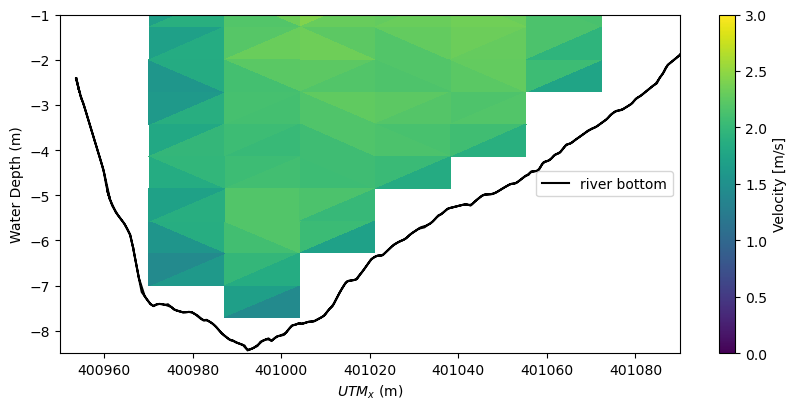

In [17]:
# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
    ADCP_ideal_points_downsamples.utm_x, 
    -ADCP_ideal_points_downsamples.waterdepth, 
    ADCP_ideal_downsamples.magnitude*river_bottom_filter_downsampled,
    vmin=min_plot,
    vmax=max_plot
    )

# Plot river bottom for comparison
plt.plot(ideal_points.utm_x,-bottom_avg,'k', label= 'river bottom')

# Plot Settings
plt.xlabel('$UTM_x$ (m)')
plt.ylabel('Water Depth (m)')
cbar= plt.colorbar(contour_plot)
cbar.set_label('Velocity [m/s]')
plt.ylim([-8.5,-1])
plt.xlim([400950,401090])
plt.legend(loc= 7)

 ## 2. Delft3D Data
 
Typically researchers use a modeling tool such as Deflt3D which, relative to field deployments, can perform low-cost simulations where changes to the environment can be implemented and interpreted quickly. This allows researchers to narrow in on a limited design set for field investigation thereby increasing the efficiency of field deployments. To initiate the numerical model, a 2010 bathymetry survey taken by Terrasond under contract to the University of Alaska Fairbanks (UAF) was used to represent the domain. This domain was discretized using the Delft3D built-in mesh generation tool, RGF grid, to roughly 5m x 5m unstructured squares from a bird's eye view. Delft3D represents depth using shallow water equations with a sigma layer approach which distributes the layers between the specified bottom of the river and the water level. An initial 12 sigma layers were specified to compare to filed data for this study. The domain was simulated in Delft3D at a constant discharge of $1789 
 m^{3}/s$ and a $2.7 m$ water level, as recorded by the USGS survey station for August $10^{th}$ 2010.  The simulation shown in the example is designed to match the experimental conditions of when the ADCP plotted above was collected. The Delft3D model takes inputs of water level, discharge, and the river bathymetry. The United States Geological Survey (USGS) has a data collection downstream of the TRTS (station:"15515500"). The water level and discharge are taken from the USGS data, and the bathymetry data was collected in is the summer of 2010. In this example we will show how to get data from the USGS station and then jump to analyzing the output from the Delft3D model.
 

### D3D: USGS Water Level
The United States Geological Survey has a nearby survey station (#15515500) downstream of the TRTS which records discharge and water level. The MHKiT River module has the capability to request data from USGS survey stations as demonstrated in the river example. Using MHKiT's river module the water level for the USGS station was collected for the same day as the ADCP data was collected. The USGS assigns a parameter number of '00065' for water level or Gage height. The water level was averaged to be roughly 2.7m. This number is directly input into the Delft3D model and isn't used in this example notebook. Further examples of using the river module are shown in the `river_example`. Similar to the water level the discharge was found using the same MHKit river module except swapping out the parameter number for '00060' to get the discharge data. The discharge was averaged to be 1789 $m^3/s$. This value was also directly input to the Delft3D model and isn't used in this example notebook.

Data request URL:  https://waterservices.usgs.gov/nwis/iv/?format=json&sites=15515500&startDT=2010-08-10&endDT=2010-08-10&parameterCd=00065&siteStatus=all
Data request URL:  https://waterservices.usgs.gov/nwis/iv/?format=json&sites=15515500&startDT=2010-08-10&endDT=2010-08-10&parameterCd=00060&siteStatus=all


Text(0, 0.5, 'Dischage ($f^3/s$)')

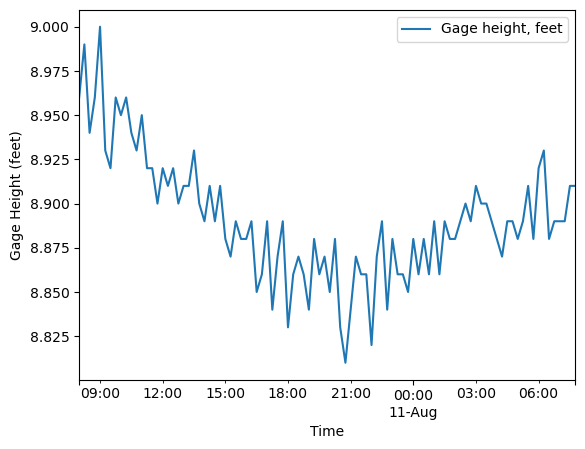

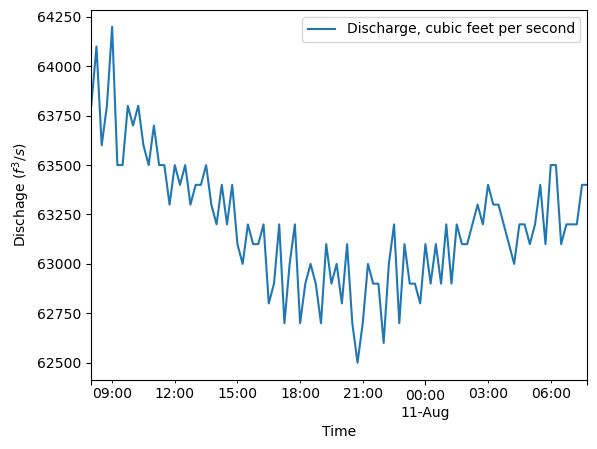

In [18]:
# Use the requests method to obtain 1 day of instantneous gage height data
water_level_USGS_data = river.io.usgs.request_usgs_data(
    station="15515500",
    parameter='00065',
    start_date='2010-08-10',
    end_date='2010-08-10',
    data_type='Instantaneous'
    )

# Plot data
water_level_USGS_data.plot()

# Plot Settings
plt.xlabel('Time')
plt.ylabel('Gage Height (feet)')

# Use the requests method to obtain 1 day of instantneous discharge data
discharge_USGS_data = river.io.usgs.request_usgs_data(
    station="15515500",
    parameter='00060',
    start_date='2010-08-10',
    end_date='2010-08-10',
    data_type='Instantaneous'
    )

# Print data
discharge_USGS_data.plot()
# Plot Settings
plt.xlabel('Time')
plt.ylabel('Dischage ($f^3/s$)')

### D3D: Importing Delft3D Data 
Here we are importing the NetCDF data exported by the Delft3D simulation described in the Delft3D introduction.

In [19]:
# Import the simulated data
d3d_data = netCDF4.Dataset('data/river/ADCP_transect/tanana81010_final_map.nc')

# Get the ADCP sample points
ADCP_ideal_points_downsamples_xy = ADCP_ideal_points_downsamples.rename(columns={"utm_x": "x", "utm_y": "y"})

### D3D: Ideal Transect Data
Next, we get the velocity data at the same points as the down-sampled ideal ADCP data. In Delft3D velocity in the y direction is `ucy`, velocity in the x direction is `ucx` and velocity in the z direction is `ucz`. From these velocity components the velocity magnitude is calculated using the root mean squared formula.

In [ ]:
# Interpolate the Delft3D simulated data onto the the sample points
variables= ['ucy', 'ucx', 'ucz']
D3D= d3d.variable_interpolation(d3d_data, variables, points= ADCP_ideal_points_downsamples_xy)

# Calculate the magnitude of the velocity
D3D['magnitude'] = np.sqrt(D3D.ucy**2 + D3D.ucx**2 + D3D.ucz**2)

points provided


Using our Delft3D velocity magnitude a contour plot is created. The results are plotted with the original ideal ADCP river bottom for reference.

In [ ]:
# Plot Delft3D interpolated Data
plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
    D3D.x, 
    -D3D.waterdepth, 
    D3D.magnitude*river_bottom_filter_downsampled,
    vmin=min_plot,
    vmax=max_plot,
    #shading='gouraud'
    alpha=1
)

# Plot the river bottom calculated frol ADCP for comparison
plt.plot(ideal_points.utm_x,-bottom_avg,'k', label= 'river bottom')

# Figure settings
plt.xlabel('$UTM_x (m)$')
plt.ylabel('Water Depth (m)')
cbar= plt.colorbar(contour_plot)
cbar.set_label('velocity [m/s]')
plt.ylim([-8.5,-1])
plt.xlim([400960,401090])
plt.legend(loc= 7)

## 3. Error Calulations
Data from Delft3D and the ADCP were now on an equivalent set of points in our data processing environment. For comparison the $L_1$, $L_2$, and $L_{\infty}$ norms were calculated for the Delft3D transect, and the down-sampled ADCP data. The L1 norm is equal to the absolute value of the difference between modeled and measured velocities, Delft3D and ADCP, respectively, over the measured velocity. This gives a fraction that can be converted into the percent difference between measured and modeled velocities. The mean absolute error (MAE) in is an average value of L1. The error calculation process was repeated to calculate the L2 norm which is commonly referred to as the mean squared error (MSE). $L_1$, $L_2$, and $L_{\infty}$ are dimensionless.

### Error:  L1 

$L_1= \frac{|D3D-ADCP|}{ADCP}$

$L_1$ is a dimensionless value equal to the difference between the modeled and measured value divided by the actual value. In this case the measured ADCP is considered to be the actual value.

In [ ]:
# L1
L1_Magnitude= abs(ADCP_ideal_downsamples.magnitude-D3D.magnitude)/ADCP_ideal_downsamples.magnitude

Similar to the `river_bottom_filter` this filter replaces extreme values (100%) values with 'nan' and is then combined with the `river_bottom_filter` to create `error_filter`. 

In [ ]:
river_bottom_edge_filter_downsampled= []
for i in  L1_Magnitude:
    if 1 > i: 
        filter= 1    
    else: 
        filter= float("nan")
    river_bottom_edge_filter_downsampled= np.append(river_bottom_edge_filter_downsampled, filter)
    
error_filter = river_bottom_edge_filter_downsampled*river_bottom_filter_downsampled

The mean absolute error (MAE) is the average $L_1$ error over the transect area. The MAE is displayed with the fil contour plot of $L_1$. $N$ is equation is equle to the number of points in the river cross-sectional area. 

$MAE= \frac{\sum{L_1}}{N}$

In [ ]:
# Calculate and priont the Mean Absolute Error
MAE= np.sum(L1_Magnitude*error_filter)/len(L1_Magnitude[L1_Magnitude< 1000 ])
MAE

In [ ]:
# Set the min and max error values
max_plot=1
min_plot=0

# Plotting the L1 error
plt.figure(figsize=(10,4.4))
contour_plot_L1 = plt.tripcolor(
    D3D.x, 
    -D3D.waterdepth, 
    L1_Magnitude*error_filter,
    vmin=min_plot,
    vmax=max_plot
    )

# Plot the river bottom for comparison
plt.plot(ideal_points.utm_x,-bottom_avg,'k', label= 'river bottom')

# Plot settings
plt.xlim([400960,401090])
plt.ylim([-8.5,-1])
plt.xlabel('UTM x (m)')
plt.ylabel('Water Depth (m)')
cbar= plt.colorbar(contour_plot_L1)
cbar.set_label('L1 velocity error')
plt.legend(loc= 7)



### Error: L2

$L_2=\sqrt{\left(\frac{D3D-ADCP}{ADCP}\right)^2}$

$L_2$ is similar to $L_1$ except $L_2$ squares the difference between the modeled and measured values.

In [ ]:
# L2 
L2_Magnitude= np.sqrt(((ADCP_ideal_downsamples.magnitude-D3D.magnitude)/ADCP_ideal_downsamples.magnitude)**2)

The root mean squared error (RMSE) is the average of $L_2$ error over the transect area. $N$ is equation is equle to the number of points in the river cross-sectional area. 

$RMSE= \frac{\sum{L_2}}{N}$

In [ ]:
RMSE=np.sum(L2_Magnitude*error_filter)/np.size(L2_Magnitude[L2_Magnitude< 1000])
RMSE

In [ ]:
# Create a contour plot of the error
max_plot=1
min_plot=0
# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot_L2 = plt.tripcolor(
    D3D.x, 
    -D3D.waterdepth, 
    L2_Magnitude*error_filter,
    vmin=min_plot,
    vmax=max_plot
)

# Plot the river bottom for comparison
plt.plot(ideal_points.utm_x,-bottom_avg,'k', label= 'river bottom')

# Plot settings
plt.xlim([400960,401090])
plt.ylim([-8.5,-1])
plt.xlabel('UTM x (m)')
plt.ylabel('Water Depth (m)')
cbar= plt.colorbar(contour_plot_L1)
cbar.set_label('L2 velocity error')
plt.legend(loc= 7)

### Error: $L_\infty$

$L_\infty = max(L_1)$

$L_\infty$ is the maximum L1 error 

In [ ]:
# L inf
L_inf=np.nanmax(L1_Magnitude*error_filter)
L_inf

## 4. Discussion

A model verification using simulated data of TRTS was compared to field data collected in 2010 using MHKiT. This example showcased the functionality of the MHKiT river and DOLfYN modules using a real-world study. The findings demonstrated how MHKiT modules may be combined to analyze simulated data and collected field data in a simple and quick manner. Other transect plotting software run separately from data analysis software. MHKiT's ability to process data from multiple common marine energy sources will help ME practitioners reach unique and novel results quickly by eliminating much of the start-up processing scripts most analysts must perform and maintain today. Although this is a river example, this framework of analysing modeled data and comparing it to wave and tidal experimental data is possible as well.

The high error values found between the model and field data were expected for a first attempt on a coarse numerical model domain. The coarse model domain allows MHKiT to host the data in this repository for public use and replication of this study's results. This example further allows users to swap in their own data and build on this working example. Using this template the TRTS Delft3D model may now be tuned and easily compared to the error metrics calculated to improve our Delft3D Tanana River model. Looking forward, a primary focus of model improvement would be the resolution of the Delft3D model, especially on the TRTS section of the Tanana river. Improving the Delft3D model is of particular interest to the TRTS staff as it can be used to predict the impact of the wake of a CEC on the surrounding environment such as the river bottom before it's deployed long-term. This can save time and funding when implementing CECs onto an electrical grid while also mitigating environmental impact.